In [27]:
import os
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.svm import SVC
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix

# data_file_name = '../StudyData/Data_FDC_0714/'
data_file_name = '../StudyData/Data_FDC/'
# data_file_name = '../StudyData/Data_FDC_0811/'
control_channel_number = 1
test_channel_number = 3
# test2_channel_number = 4
data_length = 60
smooth_box = 10
folder_of_classifier = '../StudyData/Model_SVM/'

In [28]:
def smooth(data_in, box_pts):
    data = data_in.copy()
    box = np.ones(box_pts)/box_pts  # mean kernel (could change)
    data_smooth = np.convolve(data, box, mode='same')
    return data_smooth

In [80]:
def fdc_data_loading(f_file_name, f_system_model, f_data_length, f_smooth_box):

    np_all_data = np.empty((0, f_data_length))
    np_all_label = np.empty((0, 1))

    # read data name
    data_name_list = os.listdir(f_file_name)
    data_name_list.sort()
    for data_name in data_name_list:
#         print(data_name)
        label_buffer = data_name.split('_')

        # choose csv length
        if len(label_buffer) < 4:
            continue

        # choose csv channel (system model == control or test)
        system_model = 'C' + str(f_system_model)
        # if label_buffer[1] != 'C4':
        if label_buffer[1] != system_model:
            # print(label_buffer[1])
            continue

        # load label and data
        label_data = label_buffer[2]
        # print(label_data)
        raw_data = pd.read_csv(f_file_name + data_name, header=None)
        # useful_data = raw_data.loc[1:, [2 + f_system_model, 6 + f_system_model, 10 + f_system_model]].to_numpy()
        useful_data = raw_data.loc[1:, [2 + f_system_model]].to_numpy()

        useful_data = useful_data.astype(np.float64)
#         print(useful_data)

        # delete the data which too short
        if len(useful_data) <= f_data_length:
#             print("continue")
            continue
        # data_to_1d = np.concatenate((useful_data[0:f_data_length, 0],
        #                              useful_data[0:f_data_length, 1], useful_data[0:f_data_length, 2]), axis=0)
        data_to_1d = useful_data[0:f_data_length, 0]
        
        # combine all the data and the label in the file
        np_all_data = np.vstack((np_all_data, data_to_1d))
        np_all_label = np.vstack((np_all_label, label_data))

    return np_all_data, np_all_label


def feature_extract(f_np_data):
    # print(f_np_data.shape)

    x = np.zeros((f_np_data.shape[0], 3))
    x[:, 0] = np.amax(f_np_data, axis=1)
    x[:, 1] = np.mean(f_np_data, axis=1)
    x[:, 2] = np.std(f_np_data, axis=1)
    print(str(x.shape))
    return x

In [64]:
def svm_evaluation(f_np_data, f_np_label, f_folder_of_classifier):

    features = pd.DataFrame(f_np_data)
    labels = pd.DataFrame(f_np_label)
    labels.columns = ['label']
    f_data = pd.concat([labels, features], axis=1)
    f_data_groupby = f_data.groupby('label')
    f_data_groupby_list = list(f_data_groupby)

    f_length = len(f_np_data[0, :])
    np_data_training = np.empty((0, f_length + 1))
    np_data_testing = np.empty((0, f_length + 1))
    train_set = 0.5

    for i in range(len(f_data_groupby_list)):
        f_data_np = np.asarray(f_data_groupby_list[i][1])
        train_number = int(train_set * len(f_data_np))
        np_data_training = np.vstack((np_data_training, f_data_np[:train_number]))
        np_data_testing = np.vstack((np_data_testing, f_data_np[train_number:]))
    y_train, x_train = np_data_training[:, 0].reshape(-1, ), np_data_training[:, 1:]
    y_test, x_test = np_data_testing[:, 0].reshape(-1, ), np_data_testing[:, 1:]

    print(x_train.shape)
    print(y_test)

    # model
    print("Training the model")
    laser_classifier = svm.SVC(kernel='linear')
    laser_classifier.fit(x_train, y_train)
    _Y = laser_classifier.predict(x_test)

    print("Output the results")
    confu_matrix = pd.crosstab(pd.Series(y_test), pd.Series(_Y),
                               rownames=['True'], colnames=['Predicted'], margins=True)

    if not os.path.exists(f_folder_of_classifier):
        os.makedirs(f_folder_of_classifier)
    confu_matrix.to_csv(f_folder_of_classifier + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '_confu.csv')
    pred_result = classification_report(_Y, y_test)
    system_log = open(f_folder_of_classifier + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '_system_log.txt', "a")
    system_log.write(str(pred_result))
    result = np.sum(_Y == y_test) / (len(y_test))
    system_log.write(str(result))

    print("=========")
    print(confu_matrix)
    print("=========")
    print(pred_result)
    print("=========")
    print(result)
    print("=========")
    return result

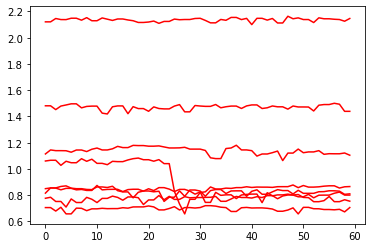

(64, 3)


In [135]:
data_file_name = data_file_name
folder_of_classifier = folder_of_classifier
data_length = data_length

# system_model = Config.control_channel_number
system_model = test_channel_number
smooth_box = smooth_box
np_data, np_label = fdc_data_loading(data_file_name, system_model, data_length, smooth_box)

# plt.plot(np_data[0*samples:(0+1)*samples,:].transpose(), 'b')
# plt.plot(np_data[1*samples:(1+1)*samples,:].transpose(), 'g')
plt.plot(np_data[2*samples:(2+1)*samples,:].transpose(), 'r')
# plt.plot(np_data[3*samples:(3+1)*samples,:].transpose(), 'c')
# plt.plot(np_data[4*samples:(4+1)*samples,:].transpose(), 'm')
# plt.plot(np_data[5*samples:(5+1)*samples,:].transpose(), 'y')
# plt.plot(np_data[6*samples:(6+1)*samples,:].transpose(), 'y')
# plt.plot(np_data[7*samples:(7+1)*samples,:].transpose(), 'y')
plt.show()

np_data3 = np_data
for i in range(np_data.shape[0]):
    
    np_data3[i,:] = smooth(np_data[i,:], smooth_box)

np_data2 = feature_extract(np_data[:,5:55])

# # print("Loaded the data")
# print(np_data2.shape)
# print(len(np_label))

# if len(np_data) == len(np_label) and len(np_data) > 1:
#     result = svm_evaluation(np_data2, np_label, folder_of_classifier)
#     print(result)

In [6]:
# np_data

In [33]:
# np_label

In [10]:
import matplotlib.pyplot as plt

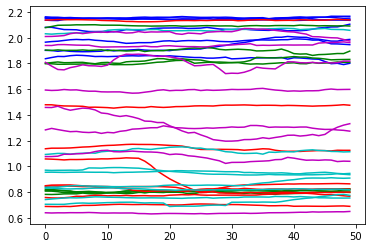

In [78]:
samples = 8
np_data = np_data3[:,5:55]
plt.plot(np_data[0*samples:(0+1)*samples,:].transpose(), 'b')
plt.plot(np_data[1*samples:(1+1)*samples,:].transpose(), 'g')
plt.plot(np_data[2*samples:(2+1)*samples,:].transpose(), 'r')
plt.plot(np_data[3*samples:(3+1)*samples,:].transpose(), 'c')
plt.plot(np_data[4*samples:(4+1)*samples,:].transpose(), 'm')
# plt.plot(np_data[5*samples:(5+1)*samples,:].transpose(), 'y')
# plt.plot(np_data[6*samples:(6+1)*samples,:].transpose(), 'y')
# plt.plot(np_data[7*samples:(7+1)*samples,:].transpose(), 'y')
plt.show()


In [15]:
data_file_name = '../StudyData/Data_FDC_0811/'

data_file_name = data_file_name
folder_of_classifier = folder_of_classifier
data_length = data_length
system_model = test_channel_number
smooth_box = smooth_box
np_data, np_label = fdc_data_loading(data_file_name, system_model, data_length, smooth_box)

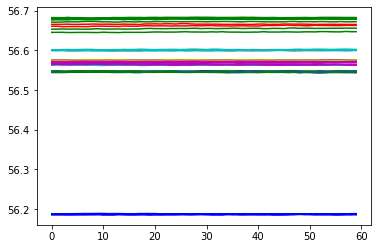

In [16]:
# plt.plot(np_data[0*15:(0+1)*15,:].transpose(), 'b')
plt.plot(np_data[1*15:(1+1)*15,:].transpose(), 'g')
plt.plot(np_data[2*15:(2+1)*15,:].transpose(), 'r')
plt.plot(np_data[3*15:(3+1)*15,:].transpose(), 'c')
plt.plot(np_data[4*15:(4+1)*15,:].transpose(), 'm')
plt.plot(np_data[5*15:(5+1)*15,:].transpose(), 'y')
plt.show()

[0.02997847 0.08993541 0.08993541 0.02997847]
[ 1.         -1.49214284  0.93756225 -0.20559164]


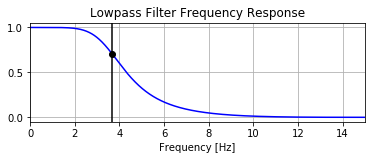

In [85]:
import numpy as np;
import matplotlib.pyplot as plt
import cv2;
import math;
from cmath import sin
from numpy.core.numeric import dtype
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft;
'''    
A few comments:
The Nyquist frequency is half the sampling rate.
You are working with regularly sampled data, so you want a digital filter, not an analog filter. This means you should not use analog=True in the call to butter, and you should use scipy.signal.freqz (not freqs) to generate the frequency response.
One goal of those short utility functions is to allow you to leave all your frequencies expressed in Hz. You shouldn't have to convert to rad/sec. As long as you express your frequencies with consistent units, the scaling in the utility functions takes care of the normalization for you.
Here's my modified version of your script, followed by the plot that it generates.
'''
 
 
 
 
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
 
 
def butter_lowpass_filter(data, cutoff, fs, order=3):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
 
 
 
 
# Filter requirements.
order = 3
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz
 
 
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)
print (b);
print (a);
# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.figure(1);
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
#plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()
 
 

/Users/ssw/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


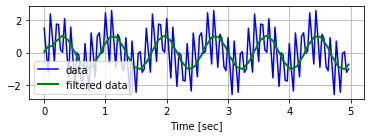

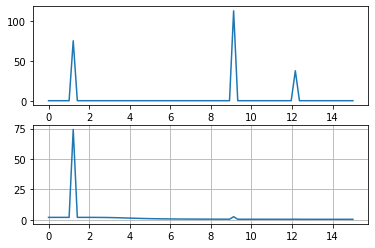

In [91]:
# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)
 
 
# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)
 
 
plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
 
 
plt.subplots_adjust(hspace=0.35)
#show the signal spetrum before and after filter.
plt.figure(2);
plt.subplot(2,1,1);
yf=fft(data);
xf=np.linspace(0.0,fs/2,n/2);
plt.plot(xf,(np.abs(yf[0:int(n/2)])));
plt.subplot(2,1,2);
yf_filter=fft(y);
plt.plot(xf,(np.abs(yf_filter[0:int(n/2)])));
plt.grid();
plt.show()

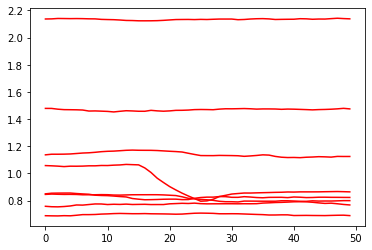

In [112]:
samples = 8
np_data = np_data3[:,5:55]
# plt.plot(np_data[0*samples:(0+1)*samples,:].transpose(), 'b')
# plt.plot(np_data[1*samples:(1+1)*samples,:].transpose(), 'g')
plt.plot(np_data[2*samples:(2+1)*samples,:].transpose(), 'r')
# plt.plot(np_data[3*samples:(3+1)*samples,:].transpose(), 'c')
# plt.plot(np_data[4*samples:(4+1)*samples,:].transpose(), 'm')
# plt.plot(np_data[5*samples:(5+1)*samples,:].transpose(), 'y')
# plt.plot(np_data[6*samples:(6+1)*samples,:].transpose(), 'y')
# plt.plot(np_data[7*samples:(7+1)*samples,:].transpose(), 'y')
plt.show()

In [140]:
np_data_denosing= np_data[:,0:50].copy()
for i in range(np_data.shape[0]):
    np_data_denosing[i, :] = butter_lowpass_filter(np_data_denosing[i, :], 0.5, 10, 1)
# print(np_data)

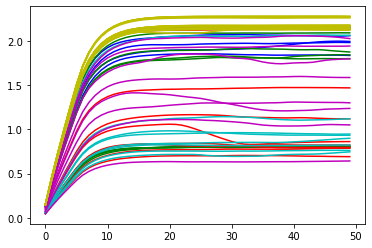

In [141]:
samples = 8
# np_data = np_data_denosing
plt.plot(np_data_denosing[0*samples:(0+1)*samples,:].transpose(), 'b')
plt.plot(np_data_denosing[1*samples:(1+1)*samples,:].transpose(), 'g')
plt.plot(np_data_denosing[2*samples:(2+1)*samples,:].transpose(), 'r')
plt.plot(np_data_denosing[3*samples:(3+1)*samples,:].transpose(), 'c')
plt.plot(np_data_denosing[4*samples:(4+1)*samples,:].transpose(), 'm')
plt.plot(np_data_denosing[5*samples:(5+1)*samples,:].transpose(), 'y')
plt.plot(np_data_denosing[6*samples:(6+1)*samples,:].transpose(), 'y')
plt.plot(np_data_denosing[7*samples:(7+1)*samples,:].transpose(), 'y')
plt.show()

20


/Users/ssw/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


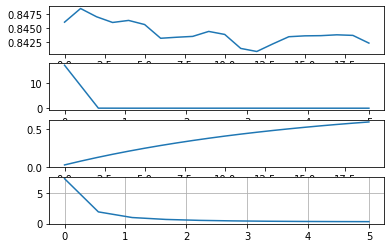

In [116]:
data = np_data[17,0:20].copy()
print(len(data))
fs = 10.0       # sample rate, Hz
n = len(data)
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
#show the signal spetrum before and after filter.


plt.figure(2);
plt.subplot(4,1,1);
plt.plot(data)

plt.subplot(4,1,2);
yf=fft(data);
xf=np.linspace(0.0,fs/2,n/2);
plt.plot(xf,(np.abs(yf[0:int(n/2)])));

cutoff = 0.1
y = butter_lowpass_filter(data, cutoff, fs, 1)

plt.subplot(4,1,3);
plt.plot(y)

plt.subplot(4,1,4);
yf_filter=fft(y);
plt.plot(xf,(np.abs(yf_filter[0:int(n/2)])));
plt.grid();
plt.show()

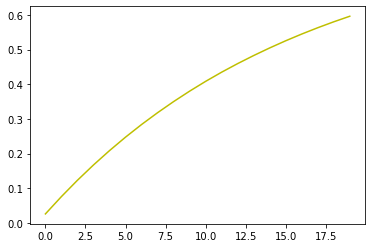

In [117]:
plt.plot(y, 'y')
plt.show()

In [142]:
a = [1, 2]
b = [3, 4]
a.extend(b)
a


[1, 2, 3, 4]

In [146]:
a = [[1, 2],[5,6]]
b = [[3, 4],[7,8]]
print(a)
print(b)
a.extend(b)
a

[[1, 2], [5, 6]]
[[3, 4], [7, 8]]


[[1, 2], [5, 6], [3, 4], [7, 8]]

In [155]:
import numpy as np
 
n = 23
CV = 10
testNum = int(np.floor(n / CV))
tempCake = [i for i in range(n)]
# print(tempCake)
for i in range(CV):
    wholeCake = np.array([i for i in range(n)])
    testIndices = np.random.choice(tempCake, size=testNum, replace=False)
    trainIndices = np.delete(wholeCake, testIndices)
    for ele in testIndices:
        tempCake.remove(ele)
    print(tempCake)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 15, 16, 17, 21]
[0, 1, 2, 4, 5, 7, 9, 10, 13, 15, 16, 17, 21]
[1, 4, 5, 7, 9, 10, 13, 15, 16, 17, 21]
[1, 4, 5, 7, 9, 10, 13, 15, 21]
[1, 4, 5, 10, 13, 15, 21]
[1, 5, 10, 15, 21]
[1, 5, 10]


In [177]:
import numpy as np
import math

n = 23
ten_fold_cross = 10
testNum = int(n / CV)
testNumAdd = int(n % CV)
print(testNum)
print(testNumAdd)

tempCake = [i for i in range(n)]
tempCakeAdd = [0 for i in range(ten_fold_cross)]
for i in range(testNumAdd):
    tempCakeAdd[i] = 1
print(tempCake)
print(tempCakeAdd)

# testNum+1 * testNumAdd
ten_fold_set_list = []

for i in range(CV):    
    if tempCakeAdd[i] == 1:
        test_set = tempCake[i*(testNum+1):(i+1)*(testNum+1)]
#         print(test_set)
        ten_fold_set_list.append(test_set)
    else:
        index = (testNum+1) * testNumAdd
        test_set = tempCake[index + (i-testNumAdd)*testNum:index + (i-testNumAdd +1)*testNum]
#         print(test_set)
        ten_fold_set_list.append(test_set)
ten_fold_set_list
#     wholeCake = np.array([i for i in range(n)])
#     testIndices = np.random.choice(tempCake, size=testNum, replace=False)
#     trainIndices = np.delete(wholeCake, testIndices)
#     for ele in testIndices:
#         tempCake.remove(ele)
#     print(tempCake)

2
3
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


[[0, 1, 2],
 [3, 4, 5],
 [6, 7, 8],
 [9, 10],
 [11, 12],
 [13, 14],
 [15, 16],
 [17, 18],
 [19, 20],
 [21, 22]]

In [218]:
def get_ten_set_of_time(f_np_label):
    ten_fold_set_list = []
#     n_length = len(f_np_label)
    n_length = 8
    ten_fold = 10
    each_set_number = int(n_length / ten_fold)
    first_x_set_add = int(n_length % ten_fold)
    index_last_y = (each_set_number + 1) * first_x_set_add
    all_index_set = [i for i in range(n_length)]
    for i in range(ten_fold):
        if i < first_x_set_add:
            ten_fold_set_list.append(all_index_set[i * (each_set_number + 1):(i + 1) * (each_set_number + 1)])
        else:
            ten_fold_set_list.append(all_index_set[index_last_y + (i -first_x_set_add) * each_set_number :
                                                   index_last_y + (i -first_x_set_add + 1) * each_set_number ])
    if n_length < ten_fold:
        for i in range(ten_fold - n_length):
            ten_fold_set_list[n_length + i] = [n_length - 1]
    return ten_fold_set_list

In [219]:
get_ten_set_of_time(4)

[[0], [1], [2], [3], [4], [5], [6], [7], [7], [7]]

In [222]:
# np_data

In [223]:
# np_label

In [253]:
def ten_fold_cross_validation(f_np_data, f_np_label):

    # group each label
    features = pd.DataFrame(f_np_data)
    labels = pd.DataFrame(f_np_label)
    labels.columns = ['label']
    f_data = pd.concat([labels, features], axis=1)
    f_data_groupby = f_data.groupby('label')
    f_data_groupby_list = list(f_data_groupby)
    f_group_ten_set_list = []
    
#     f_length = len(f_np_data[0, :])
#     np_data_training = np.empty((0, f_length + 1))
#     np_data_testing = np.empty((0, f_length + 1))
# #     train_set = 0.5
    
    for i in range(len(f_data_groupby_list)):
        f_group_ten_set_list.append(np.asarray(f_data_groupby_list[i][1]))
#         f_data_np = np.asarray(f_data_groupby_list[i][1])
        
#         np_data_training = np.vstack((np_data_training, f_data_np[:train_number]))
#         np_data_testing = np.vstack((np_data_testing, f_data_np[train_number:]))
    
#     len(f_group_ten_set_list)    
    
    
    
#     f_length = len(f_np_data[0, :])
#     np_data_training = np.empty((0, f_length + 1))
#     np_data_testing = np.empty((0, f_length + 1))
#     train_set = 0.5

#     for i in range(len(f_data_groupby_list)):
#         f_data_np = np.asarray(f_data_groupby_list[i][1])
#         train_number = int(train_set * len(f_data_np))
#         np_data_training = np.vstack((np_data_training, f_data_np[:train_number]))
#         np_data_testing = np.vstack((np_data_testing, f_data_np[train_number:]))
#     y_train, x_train = np_data_training[:, 0].reshape(-1, ), np_data_training[:, 1:]
#     y_test, x_test = np_data_testing[:, 0].reshape(-1, ), np_data_testing[:, 1:]
        
    return f_group_ten_set_list

In [254]:
aa = ten_fold_cross_validation(np_data, np_label)

In [259]:
bb = aa[0][:,1:]

In [260]:
len(bb)

8

In [263]:
ten_fold_set_list = []
ten_fold_data_set_list = []
n_length = len(bb)
# n_length = 8
ten_fold = 10
each_set_number = int(n_length / ten_fold)
first_x_set_add = int(n_length % ten_fold)
index_last_y = (each_set_number + 1) * first_x_set_add
all_index_set = [i for i in range(n_length)]
for i in range(ten_fold):
    if i < first_x_set_add:
        ten_fold_set_list.append(all_index_set[i * (each_set_number + 1):(i + 1) * (each_set_number + 1)])
        ten_fold_data_set_list.append(bb[ i * (each_set_number + 1):(i + 1) * (each_set_number + 1), : ])
    else:
        ten_fold_set_list.append(all_index_set[index_last_y + (i -first_x_set_add) * each_set_number :
                                               index_last_y + (i -first_x_set_add + 1) * each_set_number ])
        ten_fold_data_set_list.append(bb[index_last_y + (i -first_x_set_add) * each_set_number :
                                               index_last_y + (i -first_x_set_add + 1) * each_set_number, : ])
if n_length < ten_fold:
    ten_fold_data_set_list = ten_fold_data_set_list[0:n_length]
    for i in range(ten_fold - n_length):
        ten_fold_set_list[n_length + i] = [n_length - 1]
        ten_fold_data_set_list.append(bb[n_length - 1, :])
ten_fold_data_set_list

[array([[0.9030348153461467, 1.090968008212664, 1.2789012010791811,
         1.4664023141440874, 1.6505752009961885, 1.8370192544300707,
         1.8463486388303632, 1.8548603157875472, 1.8538897794163307,
         1.860560097833951, 1.8640387634882831, 1.8625046270257262,
         1.8591837283316435, 1.8540539301967942, 1.8547829647880636,
         1.8532408327975514, 1.854871087395627, 1.8564255941524503,
         1.8586289682792463, 1.860026529240151, 1.8582697881137025,
         1.8604318156634092, 1.860928958564505, 1.8600790633343485,
         1.8566985615908789, 1.8595312102064547, 1.8559989936450527,
         1.8528746723506586, 1.8493383019721388, 1.8463147490457457,
         1.8463938134738866, 1.8418856765450642, 1.8413590487490763,
         1.8444204383267184, 1.849091075385236, 1.8359007881761096,
         1.8379540429194692, 1.8404928576801824, 1.8449174436265063,
         1.8429790583384942, 1.8439010682007797, 1.8443996190199758,
         1.8443683075864743, 1.846658432

In [242]:
bb = aa[:4]
# bb

In [241]:
# y_train, x_train = bb[:, 0].reshape(-1, ), bb[:, 1:]
# print(y_train)
# print(x_train)

In [ ]:
f_length = len(f_np_data[0, :])
np_data_training = np.empty((0, f_length + 1))
np_data_testing = np.empty((0, f_length + 1))
